# Show block arrival times per node for a given date range
See .env.example to set the environment variables.

In [1]:
!pip install jupysql clickhouse_sqlalchemy matplotlib python-dotenv > /dev/null 2>&1

In [2]:
import dotenv
import os

dotenv.load_dotenv()

# Load and display config
start_date = os.getenv('START_DATE_TIME')
end_date = os.getenv('END_DATE_TIME')

validator_ranges_url = os.getenv('VALIDATOR_RANGES_URL')

network = os.getenv('NETWORK')

print(f"start_date: {start_date}")
print(f"end_date: {end_date}")
from datetime import datetime

# Convert start and end dates to datetime objects
start_dt = datetime.fromisoformat(start_date.replace("Z", "+00:00"))
end_dt = datetime.fromisoformat(end_date.replace("Z", "+00:00"))

# Calculate the difference in hours
hours = (end_dt - start_dt).total_seconds() / 3600

print(f"hours: {hours}")
print(f"validator_ranges_url: {validator_ranges_url}")
print(f"network: {network}")

ignored_nodes = os.getenv('IGNORED_NODES')
print(f"ignored_nodes: {ignored_nodes}")

consensus_clients = os.getenv('CONSENSUS_CLIENTS', '')
execution_clients = os.getenv('EXECUTION_CLIENTS', '')

consensus_clients = [client.strip() for client in consensus_clients.split(',') if client.strip()]
execution_clients = [client.strip() for client in execution_clients.split(',') if client.strip()]

if consensus_clients:
    print(f"Only looking at the following consensus clients: {consensus_clients}")
else:
    print(f"Looking at all consensus clients")
if execution_clients:
    print(f"Only looking at the following execution clients: {execution_clients}")
else:
    print(f"Looking at all execution clients")


start_date: 2024-09-23T22:00:00Z
end_date: 2024-09-24T09:30:00Z
hours: 11.5
validator_ranges_url: https://bootnode-1.pectra-devnet-3.ethpandaops.io/meta/api/v1/validator-ranges.json
network: pectra-devnet-3
ignored_nodes: nimbus-geth-1,teku-geth-1,lodestar-geth-1,nimbus-erigon-1
Only looking at the following consensus clients: ['nimbus', 'teku', 'lodestar', 'prym', 'grandine', 'lighthouse']
Only looking at the following execution clients: ['geth', 'erigon', 'nethermind', 'besu', 'reth']


In [3]:
# Load validator ranges
import requests

response = requests.get(validator_ranges_url)
validator_ranges = response.json()

ignored = 0

consensus_clients = os.getenv('CONSENSUS_CLIENTS', '')
execution_clients = os.getenv('EXECUTION_CLIENTS', '')

consensus_clients = [client.strip() for client in consensus_clients.split(',') if client.strip()]
execution_clients = [client.strip() for client in execution_clients.split(',') if client.strip()]

if consensus_clients:
    print(f"Only looking at the following consensus clients: {consensus_clients}")
if execution_clients:
    print(f"Only looking at the following execution clients: {execution_clients}")

def is_ignored(node):
    if ignored_nodes and node in ignored_nodes.split(','):
        return True
    if consensus_clients:
        consensus_client = node.split('-')[0]
        if consensus_client not in consensus_clients:
            return True
    if execution_clients:
        execution_client = node.split('-')[1]
        if execution_client not in execution_clients:
            return True
    return False

# Translate the validator ranges to a dictionary of validator index to node with a start and end index
validator_ranges_dict = {}
for range, node in validator_ranges['ranges'].items():
    if is_ignored(node):
        ignored += 1
        continue
    
    consensus_client = node.split('-')[0]
    execution_client = node.split('-')[1]
    start, end = range.split('-')
    validator_ranges_dict[node] = {
        'start': int(start),
        'end': int(end),
        'node': node,
        'consensus': consensus_client,
        'execution': execution_client
    }

# Show how many nodes we have
print(f"Number of nodes: {len(validator_ranges_dict)}")
print(f"Ignored nodes: {ignored}")

Only looking at the following consensus clients: ['nimbus', 'teku', 'lodestar', 'prym', 'grandine', 'lighthouse']
Only looking at the following execution clients: ['geth', 'erigon', 'nethermind', 'besu', 'reth']
Number of nodes: 35
Ignored nodes: 22


In [4]:
# Connect to ClickHouse
import os
username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')


db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"

from sqlalchemy import create_engine

engine = create_engine(db_url)

connection = engine.connect()

In [5]:
# First lookup who proposed a block within the given time range
from sqlalchemy import text

query = text("""
    SELECT 
        slot, 
        proposer_validator_index AS validator_index
    FROM default.canonical_beacon_proposer_duty 
    WHERE slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
    ORDER BY slot ASC
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
proposers = result.fetchall()

if len(proposers) == 0:
    raise ValueError("No proposers found for the given time range")

min_slot = proposers[0][0]
max_slot = proposers[-1][0]

print(f"Min slot: {min_slot}")
print(f"Max slot: {max_slot}")

if len(proposers) == 0:
    raise ValueError("No blocks found for the given time range")

print(f"Found {len(proposers)} proposers for the given time range")


Min slot: 89245
Max slot: 92695
Found 3451 proposers for the given time range


In [6]:
# Now get the min block arrival times for each node
result = connection.execute(
    text("""
    SELECT 
        slot,
        min(propagation_slot_start_diff) AS min_propagation_slot_start_diff 
    FROM default.beacon_api_eth_v1_events_block 
    WHERE slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
    GROUP BY slot
"""), {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})

block_arrival_times = result.fetchall()

if len(block_arrival_times) == 0:
    raise ValueError("No block arrival times found for the given time range")

# Convert to a dictionary
block_arrival_times_dict = {slot: min_propagation_slot_start_diff for slot, min_propagation_slot_start_diff in block_arrival_times}

print(f"Found {len(block_arrival_times_dict)} block arrival times for the given time range")


Found 2864 block arrival times for the given time range


In [7]:
# Now we want to join the proposers and the block arrival times with the validator index and the node
# Example: {'ranges': {'0-99': 'lighthouse-geth-1', '100-199': 'lighthouse-geth-2'

blocks = []
not_found = 0

# For each validator index, get the node
for slot, validator_index in proposers:
    found = False
    for node, range in validator_ranges_dict.items():
        start = int(range['start'])
        end = int(range['end'])
        if start <= validator_index <= end:
            # print(f"Validator {validator_index} proposed a block from node {node} at slot {slot}")
            blocks.append({
                'slot': slot,
                'validator_index': validator_index,
                'node': node
            })
            found = True
    if not found:
        not_found += 1

print(f"Found {len(blocks)} blocks for the given time range")
print(f"Found {not_found} validators that were not on any node")

if len(blocks) == 0:
    raise ValueError("No blocks found for the given time range")


Found 2065 blocks for the given time range
Found 1386 validators that were not on any node


## Perform Analysis
Calculate the perctiles for the `propagation_slot_start_diff` for each type of node (execution and consensus)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:

# Join the blocks with the block_arrival_times_dict. We want all the blocks that the node proposed
missing_node_blocks = {}
not_found = 0
node_blocks = {}
for block in blocks:
    slot = block['slot']
    if block['node'] not in node_blocks:
        node_blocks[block['node']] = []
    # lookup the block arrival time for the slot
    if slot in block_arrival_times_dict:
        block['arrival_time_ms'] = block_arrival_times_dict[slot]
        node_blocks[block['node']].append(block)
    else:
        missing_node_blocks[block['node']] = missing_node_blocks.get(block['node'], 0) + 1
        not_found += 1

print(f"{not_found} of the {len(blocks)} blocks were not found in the event stream. Maybe they were never proposed? They have been excluded from the analysis.")


89 of the 2065 blocks were not found in the event stream. Maybe they were never proposed? They have been excluded from the analysis.


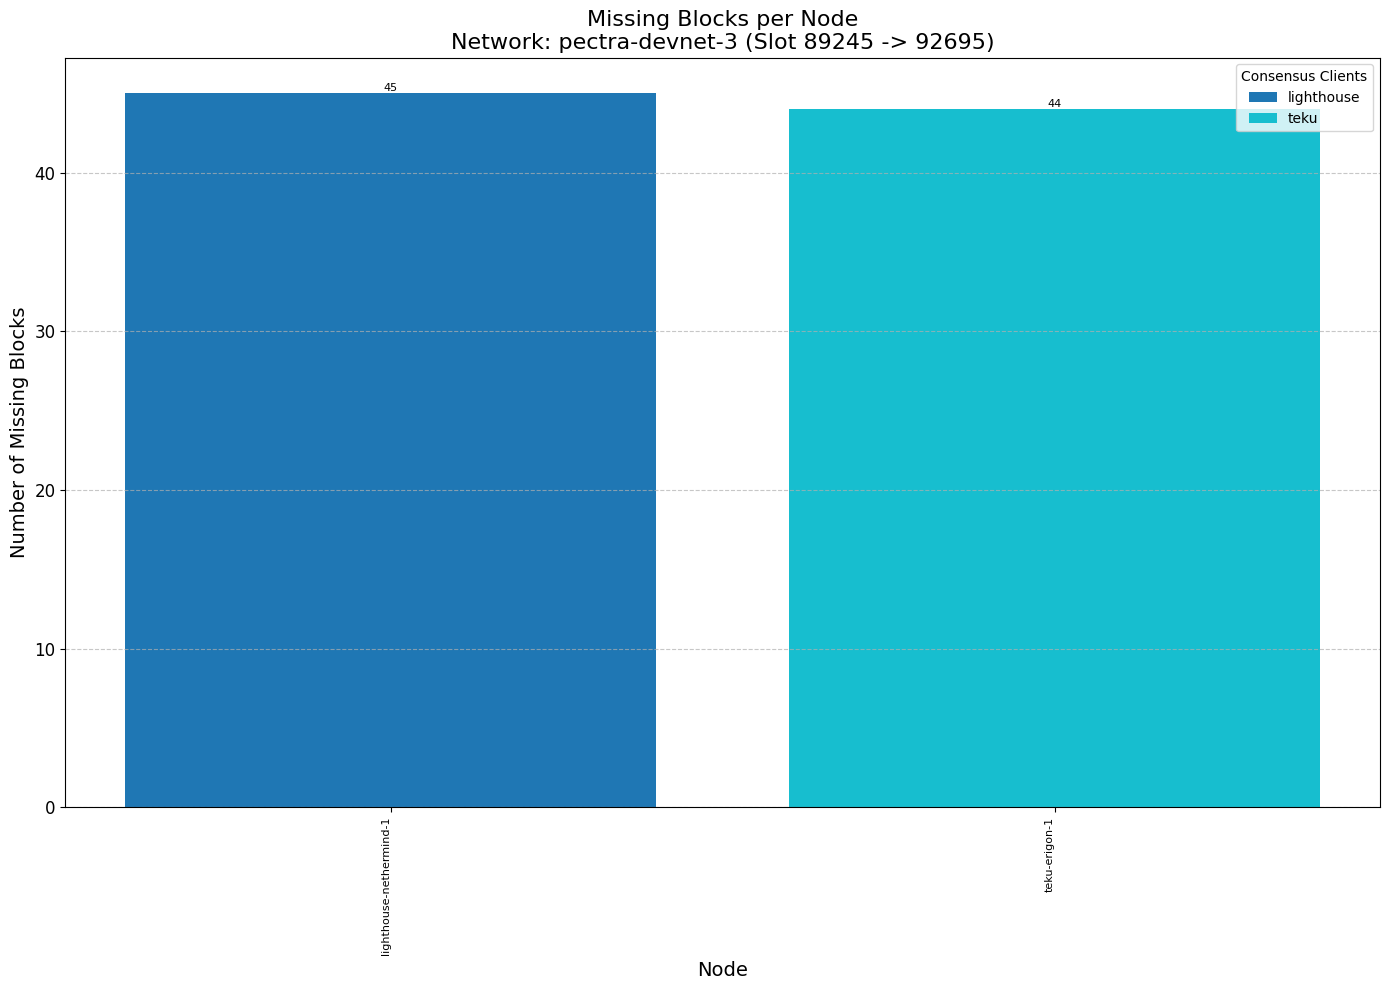

Missing blocks per node:
lighthouse-nethermind-1: 45
teku-erigon-1: 44


In [10]:
# Sort missing_node_blocks by count in descending order
sorted_missing_blocks = sorted(missing_node_blocks.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
nodes = [item[0] for item in sorted_missing_blocks]
missing_counts = [item[1] for item in sorted_missing_blocks]

# Create a color palette based on consensus clients
consensus_clients = [node.split('-')[0] for node in nodes]
unique_clients = sorted(set(consensus_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in consensus_clients]

# Plotting
plt.figure(figsize=(14, 10))
bars = plt.bar(nodes, missing_counts, color=colors)

# Customize the plot
plt.title(f"Missing Blocks per Node\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Node", fontsize=14)
plt.ylabel("Number of Missing Blocks", fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(fontsize=12)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom', fontsize=8)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for consensus clients
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_palette[i], edgecolor='none', label=client)
                   for i, client in enumerate(unique_clients)]
plt.legend(handles=legend_elements, title="Consensus Clients", loc='upper right')

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Print detailed results
print("Missing blocks per node:")
for node, count in sorted_missing_blocks:
    print(f"{node}: {count}")

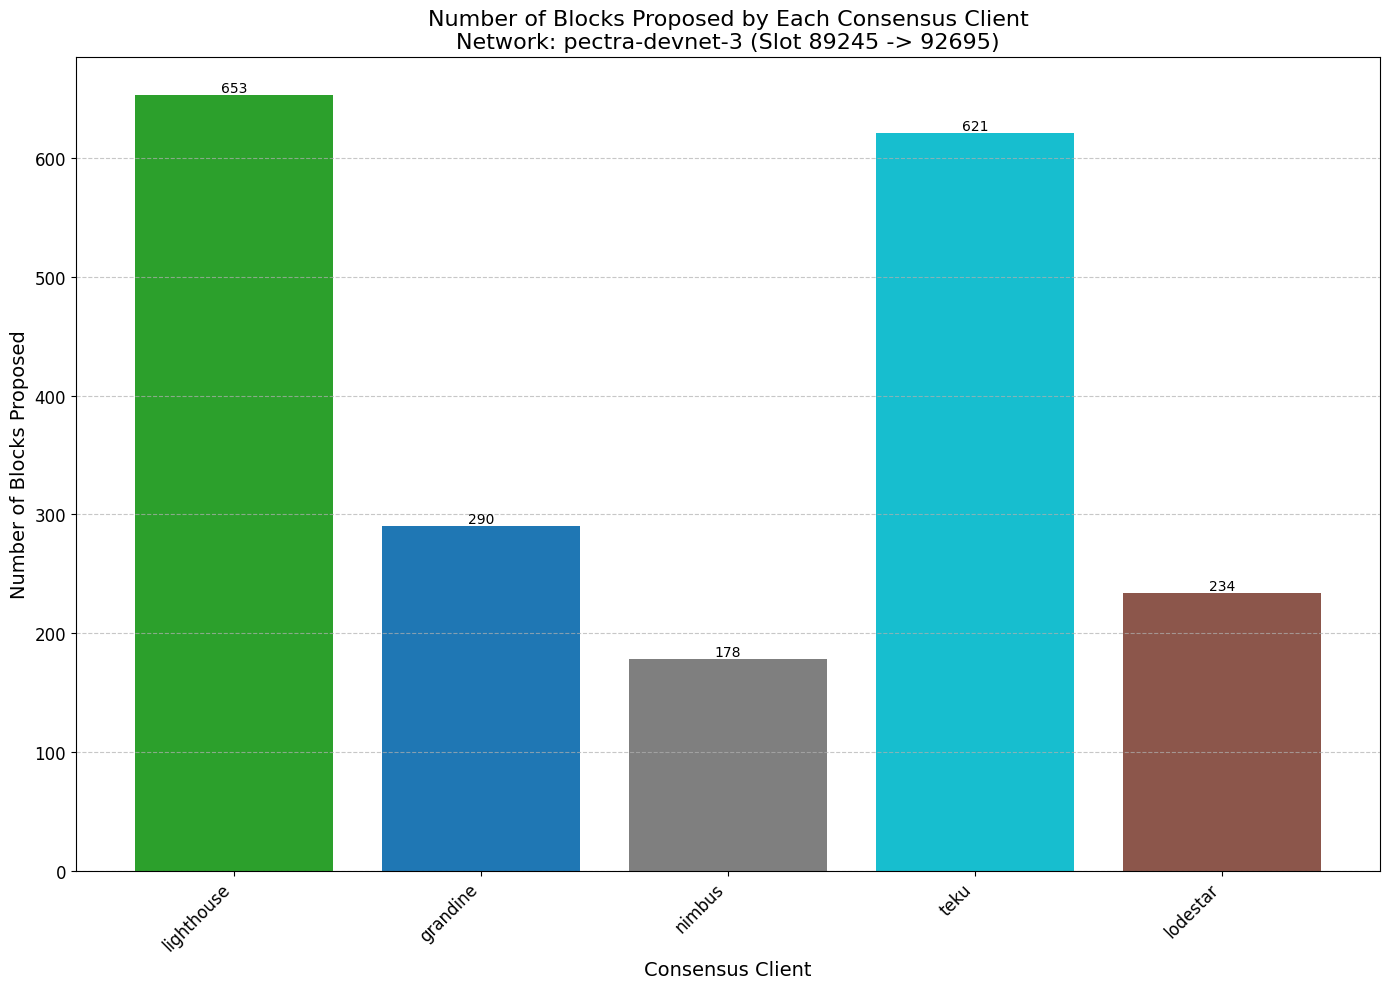

In [11]:
# Count the number of blocks proposed by each consensus client
consensus_client_counts = {}
for node, blocks in node_blocks.items():
    consensus_client = node.split('-')[0]
    consensus_client_counts[consensus_client] = consensus_client_counts.get(consensus_client, 0) + len(blocks)

# Prepare data for plotting
consensus_clients = list(consensus_client_counts.keys())
block_counts = list(consensus_client_counts.values())

# Create a color palette based on consensus clients
unique_clients = sorted(set(consensus_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in consensus_clients]

# Plotting
plt.figure(figsize=(14, 10))
bars = plt.bar(consensus_clients, block_counts, color=colors)

# Customize the plot
plt.title(f"Number of Blocks Proposed by Each Consensus Client\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Consensus Client", fontsize=14)
plt.ylabel("Number of Blocks Proposed", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom', fontsize=10)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Print detailed results (uncomment if needed)
# for client, count in consensus_client_counts.items():
#     print(f"{client} proposed {count} blocks")

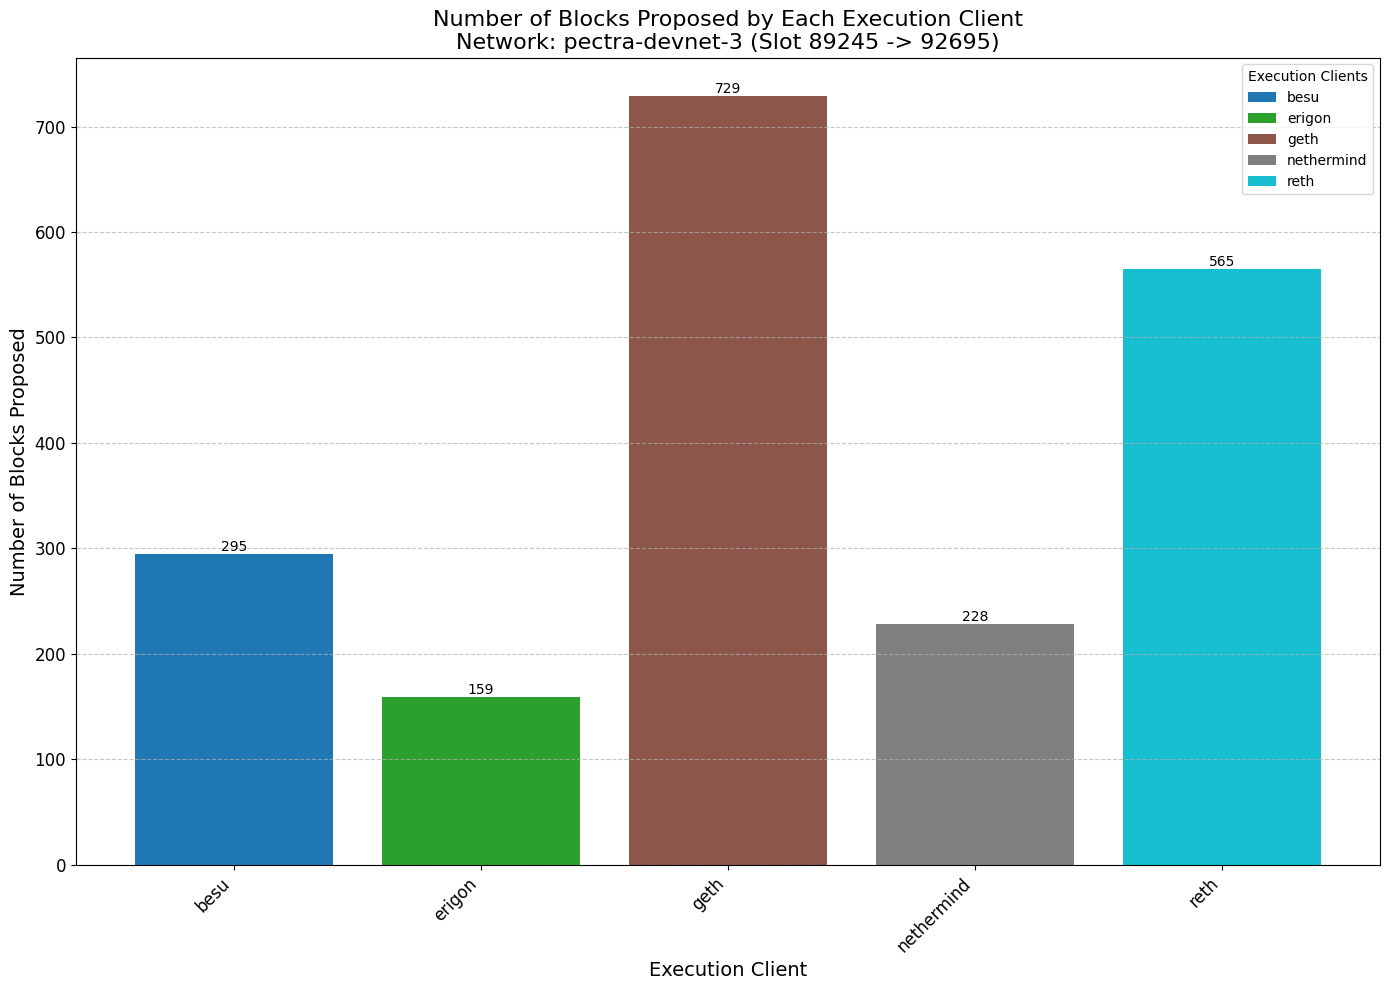

In [12]:
# Count the number of blocks proposed by each execution client
execution_client_counts = {}
for node, blocks in node_blocks.items():
    execution_client = node.split('-')[1]
    execution_client_counts[execution_client] = execution_client_counts.get(execution_client, 0) + len(blocks)

# Sort execution clients alphabetically
sorted_execution_clients = sorted(execution_client_counts.keys())

# Prepare data for plotting
block_counts = [execution_client_counts[client] for client in sorted_execution_clients]

# Create a color palette based on execution clients
unique_clients = sorted(set(sorted_execution_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in sorted_execution_clients]

# Plotting
plt.figure(figsize=(14, 10))
bars = plt.bar(sorted_execution_clients, block_counts, color=colors)

# Customize the plot
plt.title(f"Number of Blocks Proposed by Each Execution Client\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Execution Client", fontsize=14)
plt.ylabel("Number of Blocks Proposed", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom', fontsize=10)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for execution clients
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_palette[i], edgecolor='none', label=client)
                   for i, client in enumerate(unique_clients)]
plt.legend(handles=legend_elements, title="Execution Clients", loc='upper right')

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Print detailed results (uncomment if needed)
# for client in sorted_execution_clients:
#     print(f"{client} proposed {execution_client_counts[client]} blocks")

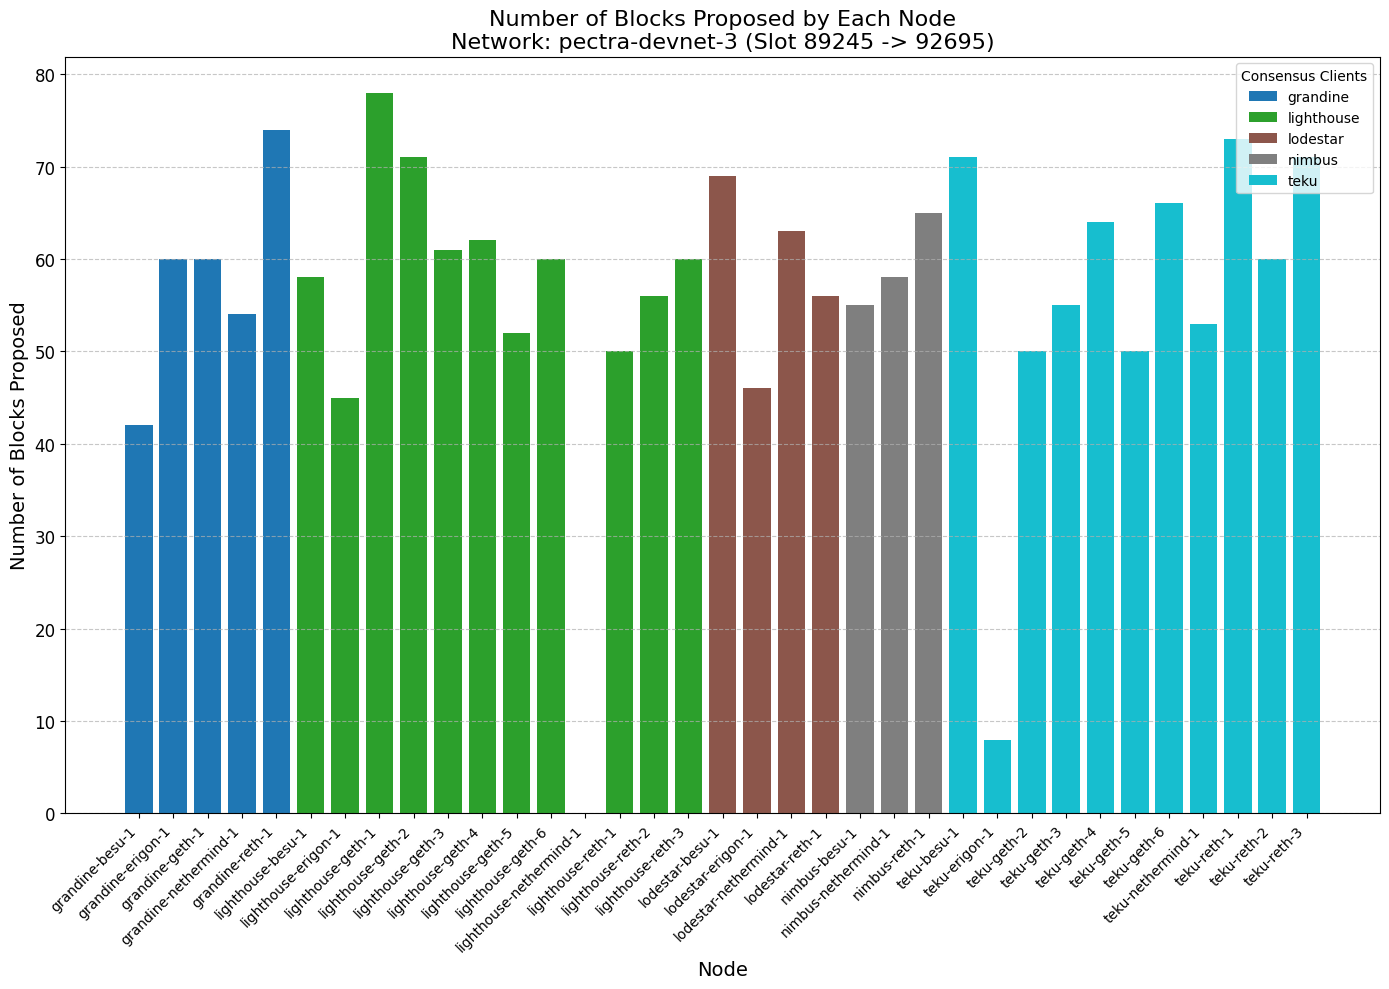

In [13]:
# Count the number of blocks proposed by each node
node_block_counts = {node: len(blocks) for node, blocks in node_blocks.items()}

# Sort nodes alphabetically
sorted_nodes = sorted(node_block_counts.keys())

# Prepare data for plotting
block_counts = [node_block_counts[node] for node in sorted_nodes]

# Create a color palette based on consensus clients
consensus_clients = [node.split('-')[0] for node in sorted_nodes]
unique_clients = sorted(set(consensus_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in consensus_clients]

# Plotting
plt.figure(figsize=(14, 10))
bars = plt.bar(sorted_nodes, block_counts, color=colors)

# Customize the plot
plt.title(f"Number of Blocks Proposed by Each Node\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Node", fontsize=14)
plt.ylabel("Number of Blocks Proposed", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for consensus clients
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_palette[i], edgecolor='none', label=client)
                   for i, client in enumerate(unique_clients)]
plt.legend(handles=legend_elements, title="Consensus Clients", loc='upper right')

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Print detailed results (uncomment if needed)
# for node in sorted_nodes:
#     print(f"{node} proposed {node_block_counts[node]} blocks")

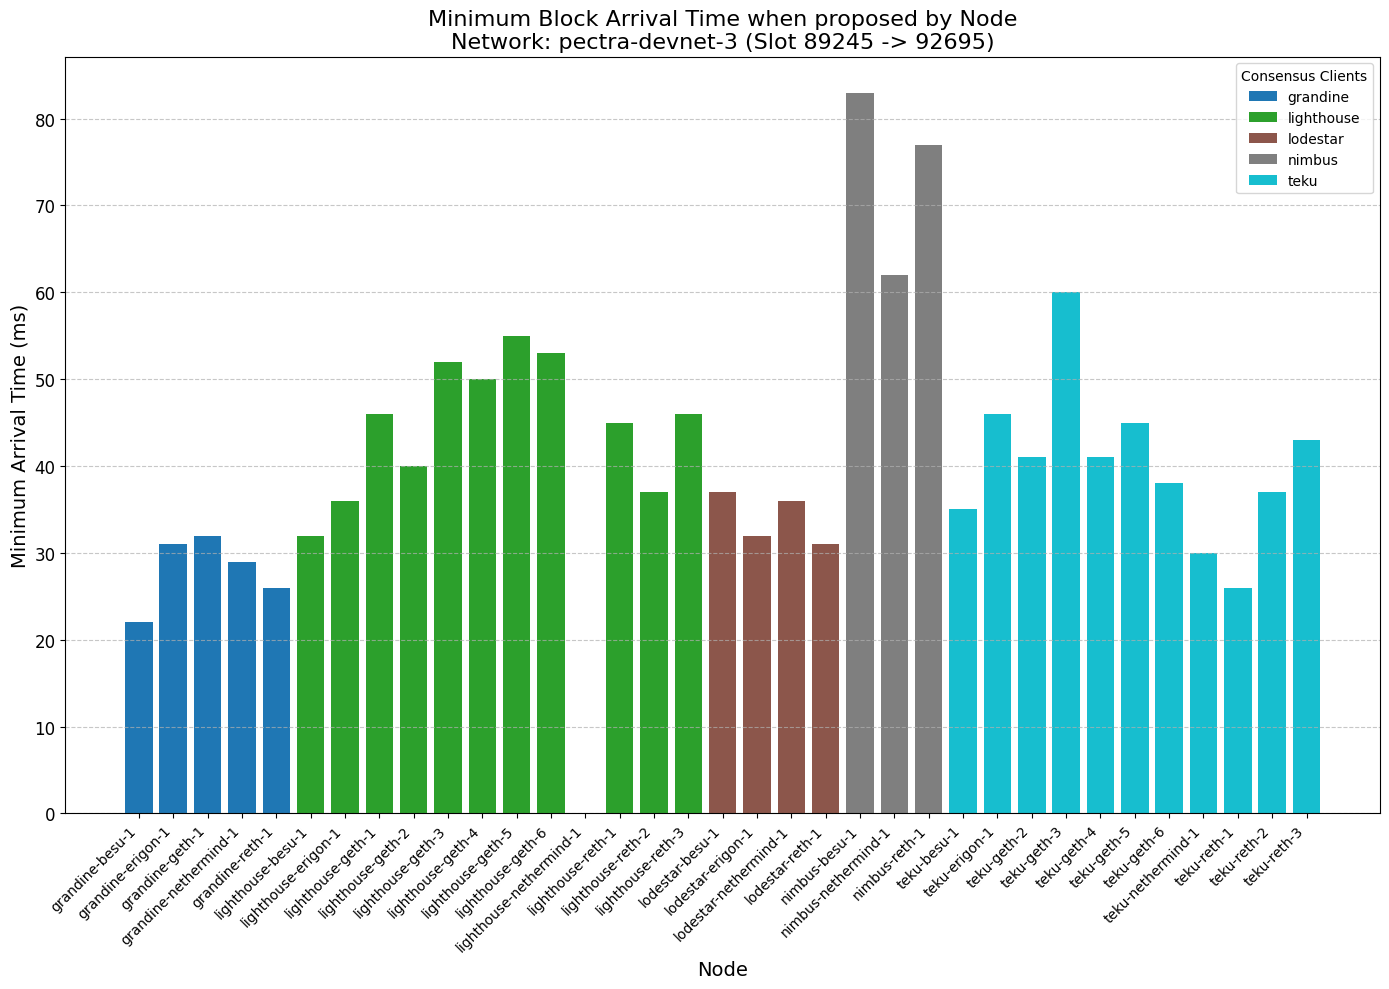

In [14]:
# Calculate minimum arrival time for each node, handling empty lists
min_arrival_times = {}
for node, blocks in node_blocks.items():
    if blocks:  # Check if the list is not empty
        min_arrival_times[node] = min(block['arrival_time_ms'] for block in blocks)
    else:
        min_arrival_times[node] = float('inf')  # Use infinity for nodes with no blocks

# Sort nodes alphabetically
sorted_nodes = sorted(min_arrival_times.keys())

# Prepare data for plotting
arrival_times = [min_arrival_times[node] for node in sorted_nodes]

# Create a color palette based on consensus clients
consensus_clients = [node.split('-')[0] for node in sorted_nodes]
unique_clients = sorted(set(consensus_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in consensus_clients]

# Plotting
plt.figure(figsize=(14, 10))
bars = plt.bar(sorted_nodes, arrival_times, color=colors)

# Customize the plot
plt.title(f"Minimum Block Arrival Time when proposed by Node\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Node", fontsize=14)
plt.ylabel("Minimum Arrival Time (ms)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for consensus clients
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_palette[i], edgecolor='none', label=client)
                   for i, client in enumerate(unique_clients)]
plt.legend(handles=legend_elements, title="Consensus Clients", loc='upper right')

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Uncomment to print detailed results
# for node in sorted_nodes:
#     if min_arrival_times[node] != float('inf'):
#         print(f"Minimum arrival time for {node}: {min_arrival_times[node]:.2f} ms")
#     else:
#         print(f"No blocks proposed by {node}")

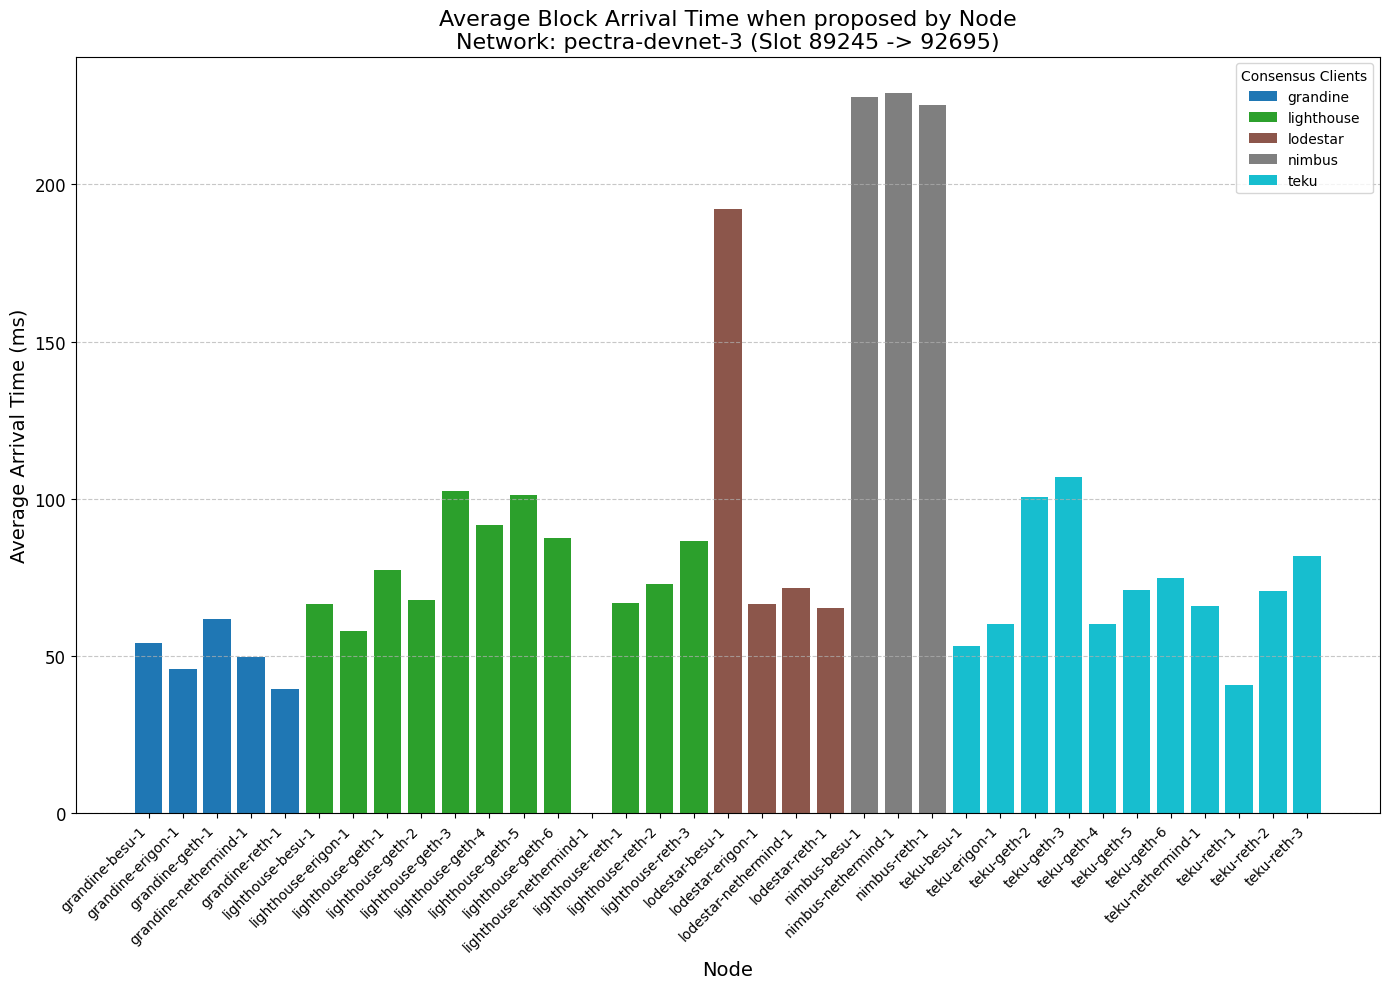

In [15]:
# Calculate average arrival time for each node, handling empty lists
avg_arrival_times = {}
for node, blocks in node_blocks.items():
    if blocks:
        avg_arrival_times[node] = sum(block['arrival_time_ms'] for block in blocks) / len(blocks)
    else:
        avg_arrival_times[node] = float('inf')  # Use infinity for nodes with no blocks

# Sort nodes alphabetically
sorted_nodes = sorted(avg_arrival_times.keys())

# Prepare data for plotting
arrival_times = [avg_arrival_times[node] for node in sorted_nodes]

# Create a color palette based on consensus clients
consensus_clients = [node.split('-')[0] for node in sorted_nodes]
unique_clients = sorted(set(consensus_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in consensus_clients]

# Plotting
plt.figure(figsize=(14, 10))
bars = plt.bar(sorted_nodes, arrival_times, color=colors)

# Customize the plot
plt.title(f"Average Block Arrival Time when proposed by Node\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Node", fontsize=14)
plt.ylabel("Average Arrival Time (ms)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for consensus clients
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_palette[i], edgecolor='none', label=client)
                   for i, client in enumerate(unique_clients)]
plt.legend(handles=legend_elements, title="Consensus Clients", loc='upper right')

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Uncomment to print detailed results
# for node in sorted_nodes:
#     if avg_arrival_times[node] != float('inf'):
#         print(f"Average arrival time for {node}: {avg_arrival_times[node]:.2f} ms")
#     else:
#         print(f"No blocks proposed by {node}")

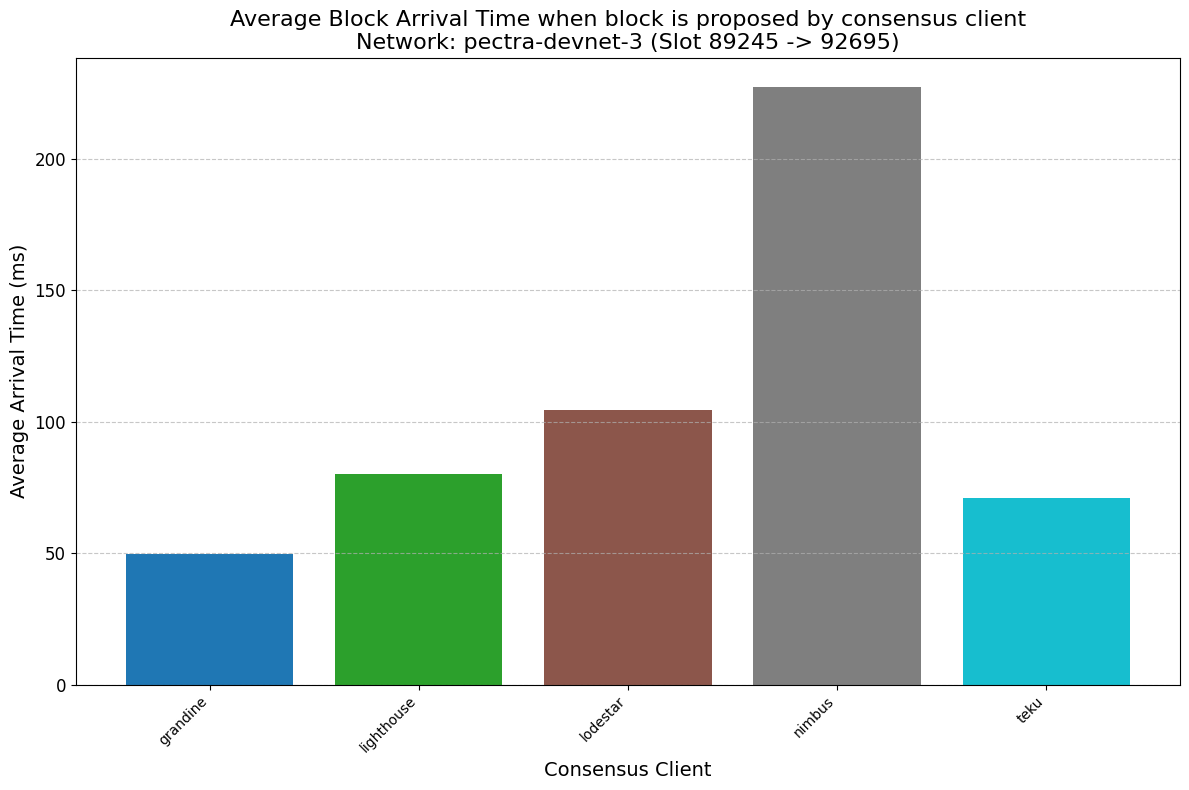

In [16]:
# Calculate average arrival time for each consensus client
client_arrival_times = {}
client_block_counts = {}

for node, blocks in node_blocks.items():
    client = node.split('-')[0]
    for block in blocks:
        if client not in client_arrival_times:
            client_arrival_times[client] = 0
            client_block_counts[client] = 0
        client_arrival_times[client] += block['arrival_time_ms']
        client_block_counts[client] += 1

avg_client_arrival_times = {client: total_time / client_block_counts[client] 
                            for client, total_time in client_arrival_times.items()}

# Sort clients alphabetically
sorted_clients = sorted(avg_client_arrival_times.keys())

# Prepare data for plotting
arrival_times = [avg_client_arrival_times[client] for client in sorted_clients]

# Create a color palette based on consensus clients
unique_clients = sorted(set(sorted_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in sorted_clients]

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(sorted_clients, arrival_times, color=colors)

# Customize the plot
plt.title(f"Average Block Arrival Time when block is proposed by consensus client\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Consensus Client", fontsize=14)
plt.ylabel("Average Arrival Time (ms)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Uncomment to print detailed results
# for client in sorted_clients:
#     print(f"Average arrival time for {client}: {avg_client_arrival_times[client]:.2f} ms")

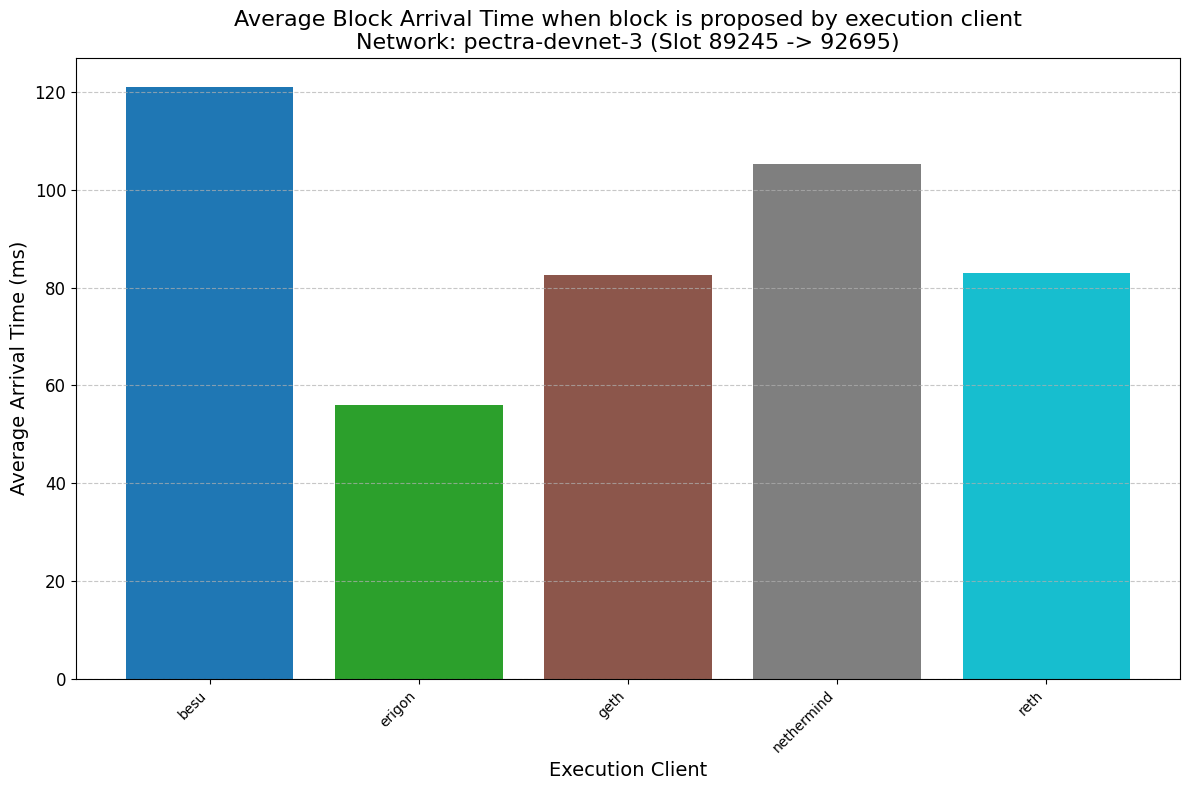

In [17]:
# Calculate average arrival time for each execution client
execution_client_arrival_times = {}
execution_client_block_counts = {}

for node, blocks in node_blocks.items():
    execution_client = node.split('-')[1]  # Assuming the execution client name is the second part of the node name
    for block in blocks:
        if execution_client not in execution_client_arrival_times:
            execution_client_arrival_times[execution_client] = 0
            execution_client_block_counts[execution_client] = 0
        execution_client_arrival_times[execution_client] += block['arrival_time_ms']
        execution_client_block_counts[execution_client] += 1

avg_execution_client_arrival_times = {client: total_time / execution_client_block_counts[client] 
                                      for client, total_time in execution_client_arrival_times.items()}

# Sort execution clients alphabetically
sorted_execution_clients = sorted(avg_execution_client_arrival_times.keys())

# Prepare data for plotting
arrival_times = [avg_execution_client_arrival_times[client] for client in sorted_execution_clients]

# Create a color palette based on execution clients
unique_execution_clients = sorted(set(sorted_execution_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_execution_clients)))
colors = [color_palette[unique_execution_clients.index(client)] for client in sorted_execution_clients]

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(sorted_execution_clients, arrival_times, color=colors)

# Customize the plot
plt.title(f"Average Block Arrival Time when block is proposed by execution client\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Execution Client", fontsize=14)
plt.ylabel("Average Arrival Time (ms)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Uncomment to print detailed results
# for client in sorted_execution_clients:
#     print(f"Average arrival time for {client}: {avg_execution_client_arrival_times[client]:.2f} ms")